In [24]:
import os
import numpy as np
import pandas as pd  # Tambahkan pandas untuk menampilkan hasil dalam bentuk tabel
from skimage.feature import graycomatrix, graycoprops
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt


In [25]:
# Fungsi untuk menghitung GLCM dan fitur tekstur dari setiap channel warna dengan 4 sudut
def calculate_glcm_features(image_channel, channel_name):
    bins = np.arange(0, 256)  # 8-bit bins
    inds = np.digitize(image_channel, bins)  # Mengelompokkan nilai intensitas berdasarkan bins
    
    max_value = inds.max() + 1
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Sudut 0°, 45°, 90°, 135°
    
    matrix_coocurrence = graycomatrix(inds, [1], angles, levels=max_value, normed=True, symmetric=True)

    # Hitung fitur GLCM untuk masing-masing properti
    features = {}
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']  # Pastikan ASM huruf besar
    for prop in properties:
        features[prop] = graycoprops(matrix_coocurrence, prop)[0]  # Mengambil hasil per sudut tanpa rata-rata
    
    return features

In [26]:
# Fungsi untuk menampilkan fitur GLCM dalam bentuk tabel menggunakan pandas
def display_features_in_table(red_features, green_features, blue_features):
    angles = ['0°', '45°', '90°', '135°']
    df = pd.DataFrame({
        "Angle": angles,
        "Red Contrast": red_features['contrast'],
        "Red Dissimilarity": red_features['dissimilarity'],
        "Red Homogeneity": red_features['homogeneity'],
        "Red Energy": red_features['energy'],
        "Red Correlation": red_features['correlation'],
        "Red ASM": red_features['ASM'],
        "Green Contrast": green_features['contrast'],
        "Green Dissimilarity": green_features['dissimilarity'],
        "Green Homogeneity": green_features['homogeneity'],
        "Green Energy": green_features['energy'],
        "Green Correlation": green_features['correlation'],
        "Green ASM": green_features['ASM'],
        "Blue Contrast": blue_features['contrast'],
        "Blue Dissimilarity": blue_features['dissimilarity'],
        "Blue Homogeneity": blue_features['homogeneity'],
        "Blue Energy": blue_features['energy'],
        "Blue Correlation": blue_features['correlation'],
        "Blue ASM": blue_features['ASM'],
    })
    print(df)

In [27]:
# Fungsi untuk memproses semua gambar dalam folder
def process_images_from_folder(folder_path):
    total_features = {
        "Red": {"contrast": [], "dissimilarity": [], "homogeneity": [], "energy": [], "correlation": [], "ASM": []},
        "Green": {"contrast": [], "dissimilarity": [], "homogeneity": [], "energy": [], "correlation": [], "ASM": []},
        "Blue": {"contrast": [], "dissimilarity": [], "homogeneity": [], "energy": [], "correlation": [], "ASM": []},
    }
    count = 0

    # Ambil semua file gambar dengan ekstensi .png
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            img = io.imread(image_path)

            # Ekstrak channel R, G, B
            red_channel = img[:, :, 0]
            green_channel = img[:, :, 1]
            blue_channel = img[:, :, 2]

            red_channel = img_as_ubyte(red_channel)
            green_channel = img_as_ubyte(green_channel)
            blue_channel = img_as_ubyte(blue_channel)

            # Hitung GLCM dan fitur untuk setiap channel
            red_features = calculate_glcm_features(red_channel, "Red")
            green_features = calculate_glcm_features(green_channel, "Green")
            blue_features = calculate_glcm_features(blue_channel, "Blue")

            # Menampilkan data ekstraksi dalam bentuk tabel
            print(f"\n==== Fitur GLCM dari Gambar {filename} ====")
            display_features_in_table(red_features, green_features, blue_features)
            print("============================================\n")

            # Tambahkan hasil fitur ke total untuk setiap channel
            for key in total_features["Red"].keys():
                total_features["Red"][key].append(red_features[key])
                total_features["Green"][key].append(green_features[key])
                total_features["Blue"][key].append(blue_features[key])

            count += 1

    # Hitung rata-rata fitur setelah semua gambar diproses untuk setiap channel dan setiap sudut
    avg_features = {}
    if count > 0:
        avg_features = {
            "Red": {key: np.mean(np.array(total_features["Red"][key]), axis=0) for key in total_features["Red"].keys()},
            "Green": {key: np.mean(np.array(total_features["Green"][key]), axis=0) for key in total_features["Green"].keys()},
            "Blue": {key: np.mean(np.array(total_features["Blue"][key]), axis=0) for key in total_features["Blue"].keys()},
        }

        # Menampilkan data rata-rata dalam bentuk tabel
        print("\n==== Rata-rata Fitur GLCM Setelah Dijumlahkan ====")
        display_features_in_table(avg_features["Red"], avg_features["Green"], avg_features["Blue"])
        print("===============================================\n")

    return avg_features

In [28]:
# Fungsi untuk memplot perbandingan antara bensin murni dan oplosan
def plot_comparison(avg_features_murni, avg_features_oplosan, property_name):
    angles = ['0°', '45°', '90°', '135°']
    plt.figure(figsize=(10, 5))
    
    plt.plot(angles, avg_features_murni["Red"][property_name], label="Murni (Red)", marker='o')
    plt.plot(angles, avg_features_oplosan["Red"][property_name], label="Oplosan (Red)", marker='o')
    
    plt.plot(angles, avg_features_murni["Green"][property_name], label="Murni (Green)", marker='o')
    plt.plot(angles, avg_features_oplosan["Green"][property_name], label="Oplosan (Green)", marker='o')

    plt.plot(angles, avg_features_murni["Blue"][property_name], label="Murni (Blue)", marker='o')
    plt.plot(angles, avg_features_oplosan["Blue"][property_name], label="Oplosan (Blue)", marker='o')
    
    plt.title(f'Perbandingan {property_name.capitalize()} antara Bensin Murni dan Oplosan')
    plt.xlabel('Sudut')
    plt.ylabel(property_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [29]:
# Tentukan folder tempat gambar berada
folder_path_murni = r'd:\kuliah\semester 5\Citra Digital\bensin_murni_crop'
folder_path_oplos = r'd:\kuliah\semester 5\Citra Digital\bensin_oplos_crop'


In [30]:
# Proses semua gambar dalam folder bensin murni dan oplosan
avg_features_murni = process_images_from_folder(folder_path_murni)
avg_features_oplosan = process_images_from_folder(folder_path_oplos)


==== Fitur GLCM dari Gambar 10murni.png ====
  Angle  Red Contrast  Red Dissimilarity  Red Homogeneity  Red Energy  \
0    0°     11.971198           0.485074         0.928044    0.854505   
1   45°     21.496469           0.659553         0.919660    0.854326   
2   90°     12.633001           0.488528         0.930282    0.854527   
3  135°     22.658657           0.671813         0.919599    0.854326   

   Red Correlation   Red ASM  Green Contrast  Green Dissimilarity  \
0         0.998958  0.730179       11.846857             0.506533   
1         0.998130  0.729873       21.280101             0.685545   
2         0.998901  0.730216       12.558541             0.511189   
3         0.998029  0.729873       22.399865             0.697330   

   Green Homogeneity  Green Energy  Green Correlation  Green ASM  \
0           0.922321      0.854349           0.998862   0.729911   
1           0.914127      0.854197           0.997956   0.729652   
2           0.924683      0.854362    

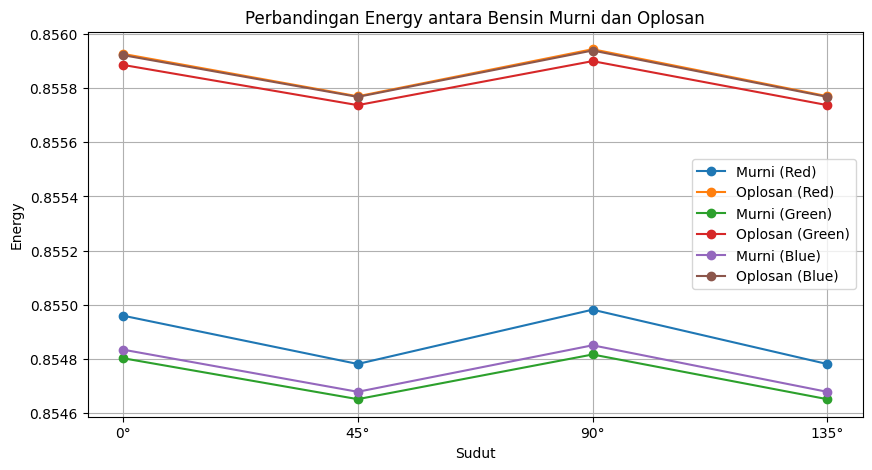

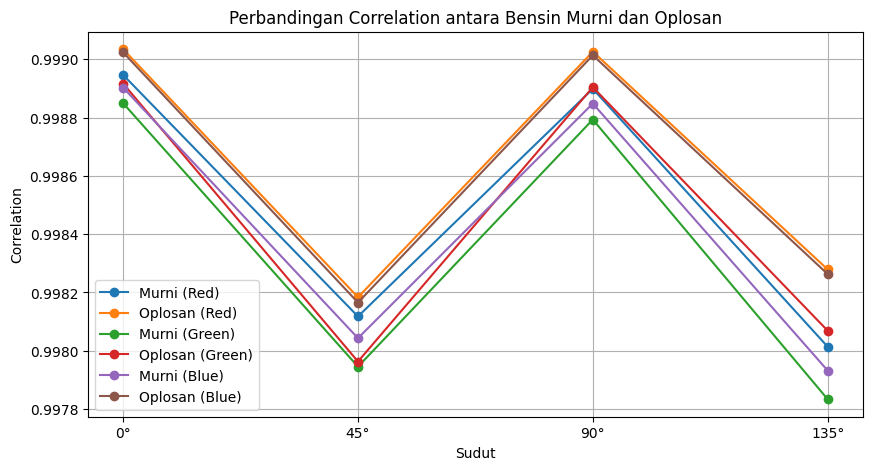

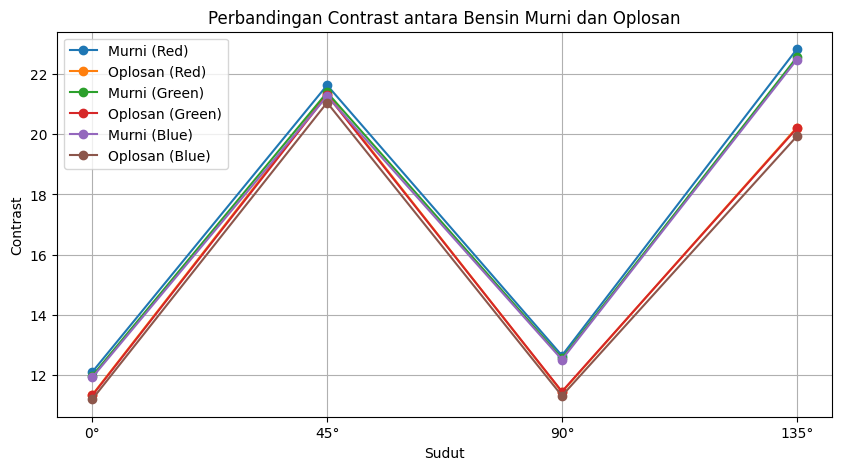

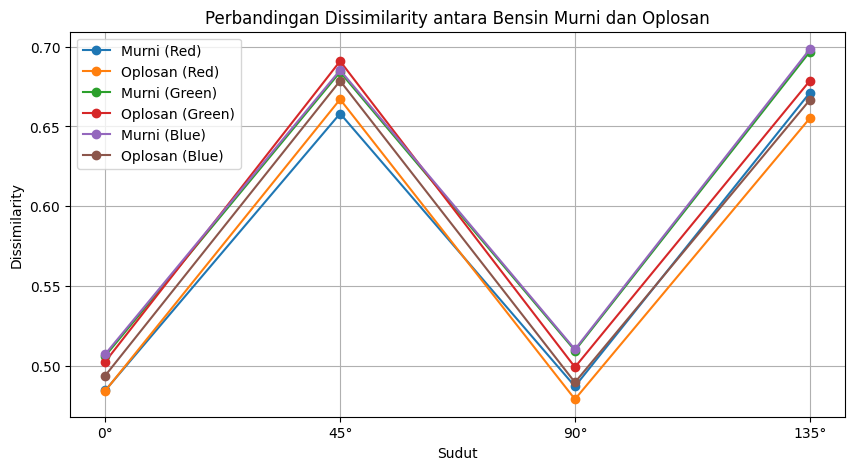

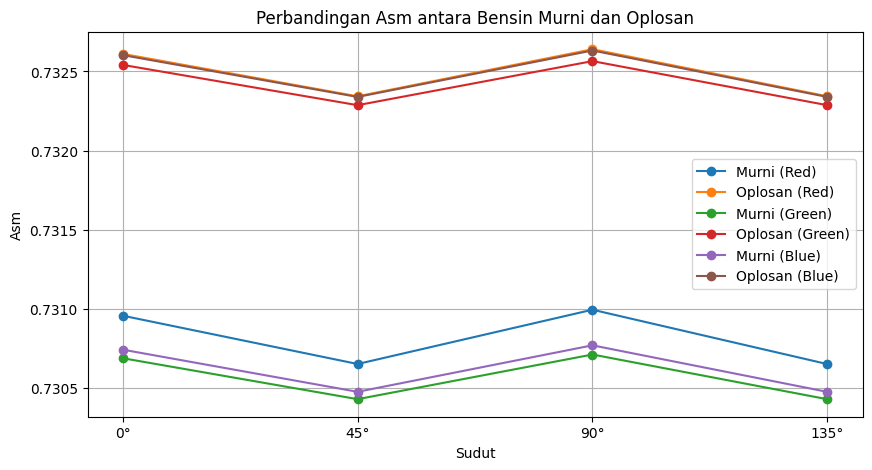

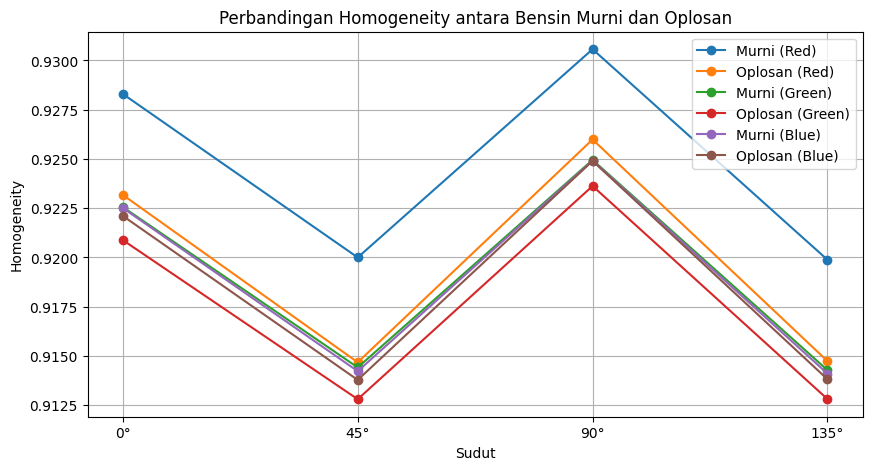

In [31]:
# Visualisasikan perbandingan untuk fitur energi dan korelasi
plot_comparison(avg_features_murni, avg_features_oplosan, 'energy')
plot_comparison(avg_features_murni, avg_features_oplosan, 'correlation')
plot_comparison(avg_features_murni, avg_features_oplosan, 'contrast')
plot_comparison(avg_features_murni, avg_features_oplosan, 'dissimilarity')
plot_comparison(avg_features_murni, avg_features_oplosan, 'ASM')
plot_comparison(avg_features_murni, avg_features_oplosan, 'homogeneity')